In [59]:
import sys
import time
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.types import StringType
from pyspark.sql import SparkSession
from pyspark import StorageLevel

import os

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
#spark = SparkSession.builder\
#            .appName("Running SQL Queries in PySpark")\
#.master("spark://login1.cluster:7078")\
#            .getOrCreate()
spark = SparkSession.builder.appName("Andrey")\
.master("spark://login1.cluster:7077")\
.config("spark.executor.memory", "50g")\
    .config("spark.driver.memory", "16g")\
.config("spark.sql.shuffle.partitions", "800")\
    .config("spark.local.dir","/scratch/jkarasev/spark/temporary")\
.config("spark.executor.cores", "15").getOrCreate()
spark.conf.set('spark.sql.caseSensitive', True)
sc = spark.sparkContext
sc.setLogLevel("INFO")  # change this to WARN for less verbosity
print('======== START ========')
start = time.time()
print("Hello from ", sc.master)
print("======== ELAPSED TIME: ", time.time() - start)

======== START ========
Hello from  spark://login1.cluster:7077
======== ELAPSED TIME:  0.0011010169982910156


/home/jkarasev/.local/lib/python3.7/site-packages/pyspark/context.py:317: FutureWarning: Python 3.7 support is deprecated in Spark 3.4.
  warnings.warn("Python 3.7 support is deprecated in Spark 3.4.", FutureWarning)


In [60]:
raw_data = sc.textFile("file:///scratch/jkarasev/openalex-snapshot-v2/data/works/updated_date=*") #("file:///scratch/jkarasev/data-copy/works/updated_date=2024-01-10")

In [61]:
import json
rdd = raw_data.map(json.loads)

In [62]:
rdd.take(1)

[{'id': 'https://openalex.org/W4312243914',
  'doi': 'https://doi.org/10.3030/750533',
  'doi_registration_agency': 'Crossref',
  'display_name': None,
  'title': None,
  'publication_year': 2002,
  'publication_date': '2002-06-20',
  'language': None,
  'ids': {'openalex': 'https://openalex.org/W4312243914',
   'doi': 'https://doi.org/10.3030/750533'},
  'primary_location': {'source': None,
   'pdf_url': None,
   'landing_page_url': 'https://doi.org/10.3030/750533',
   'is_oa': False,
   'version': None,
   'license': None,
   'doi': 'https://doi.org/10.3030/750533'},
  'best_oa_location': None,
  'type': 'grant',
  'open_access': {'is_oa': False,
   'oa_status': 'closed',
   'oa_url': None,
   'any_repository_has_fulltext': False},
  'authorships': [],
  'corresponding_author_ids': [],
  'corresponding_institution_ids': [],
  'cited_by_count': 0,
  'summary_stats': {'cited_by_count': 0, '2yr_cited_by_count': 0},
  'biblio': {'volume': None,
   'issue': None,
   'first_page': None,
  

In [63]:
def select_fields(record):
    return {
        "id": int(record.get("id").replace("https://openalex.org/W", "")),
        "year": int(record.get("publication_year",0)),
        "type": record.get("type","Empty"),
        "topics": [int(str(topic.get('field',{"id":998})['id']).replace("https://openalex.org/fields/","")) for topic in record.get("topics",[{"field":{"id":999}}])],
        "concepts": [int(concept['id'].replace("https://openalex.org/C", "")) for concept in record.get("concepts",[])], #record.get("concepts"),
        #"countries": record.get('authorships',[{"countries":[]}])[0].get("countries",[]),
        "referenced_works": [int(id.replace("https://openalex.org/W", "")) for id in record.get("referenced_works",[])] #record.get("referenced_works")
    }
rdd1 = rdd.map(select_fields)

In [64]:
rdd1.take(1)

[{'id': 4312243914,
  'year': 2002,
  'type': 'grant',
  'topics': [999],
  'concepts': [41008148],
  'referenced_works': []}]

In [65]:
rdd1.persist(StorageLevel.MEMORY_ONLY)

PythonRDD[4] at RDD at PythonRDD.scala:53

In [66]:
%%time
print(rdd1.count())

249110142
CPU times: user 6.05 s, sys: 4.61 s, total: 10.7 s
Wall time: 15min 26s


In [67]:
# Add Field with IsCS
def add_isCS_flag(item):
    if item.get("topics"):
        for topic in item["topics"]:
            if topic == 17: #concept == 41008148: # "https://openalex.org/C121332964":
                item["isCS"] = True
                return item
    item["isCS"] = False
    return item
rdd2 = rdd1.map(add_isCS_flag)

In [68]:
rdd2.persist(StorageLevel.MEMORY_ONLY)

PythonRDD[6] at RDD at PythonRDD.scala:53

In [69]:
%%time
print('======== Getting list with Is CS Flag ========')
isCS_ids = spark.sparkContext.broadcast(rdd2.filter(lambda x: x.get("isCS")).map(lambda x: x["id"]).collect())
len(isCS_ids.value)

======== Getting list with Is CS Flag ========
CPU times: user 7.25 s, sys: 3.34 s, total: 10.6 s
Wall time: 24.6 s


19579252

In [ ]:
%%time
print('======== Getting Set with Is CS Flag ========')
isCS_ids_set = spark.sparkContext.broadcast(set(rdd2.filter(lambda x: x.get("isCS")).map(lambda x: x["id"]).collect()))
len(isCS_ids_set.value)

In [ ]:
%%time
id_to_isCS_map = rdd2.filter(lambda x: x.get("isCS")).map(lambda x: (x['id'], x['isCS'])).collectAsMap()

In [22]:
# Add Field with Ref 1 CS
def add_ref1CS_flag(item):
    if item.get("referenced_works"):
        for ref_work_id in item["referenced_works"]:
            if ref_work_id in isCS_ids.value: #id_to_isCS_map.get(ref_work_id,False):    
                item["ref1CS"] = True
                return item
    item["ref1CS"] = False
    return item
rdd3 = rdd2.map(add_ref1CS_flag)

print('======== Getting list with Ref 1 CS flag ========')
start = time.time()
filtered_rdd = rdd.filter(lambda x: x.get('ref1CS')==True)
print(filtered_rdd.count())
print("======== ELAPSED TIME: ", time.time() - start)

In [23]:
%%time
rdd3.take(1)
print("Done")

Done
CPU times: user 13.2 ms, sys: 3.04 ms, total: 16.2 ms
Wall time: 2.3 s


In [38]:
processed_rdd = rdd2.map(lambda x: 
    (x["id"], x["year"], x["type"], x["topics"], x["concepts"], x["referenced_works"],x["isCS"], any(x["isCS"].get(ref_id, False) for ref_id in x["referenced_works"])))


In [52]:
def check_isCS(referenced_works):
    for ref_id in referenced_works:
        if ref_id in isCS_ids.value:
            return True
    return False
processed_rdd = rdd2.map(lambda x: 
    (x["id"], x["year"], x["type"], x["topics"], x["concepts"], x["referenced_works"],x["isCS"], check_isCS(x["referenced_works"])))


In [53]:
%%time
first_2000_records = processed_rdd.take(2000)

print("Done")

Done
CPU times: user 1.25 s, sys: 428 ms, total: 1.68 s
Wall time: 48min 10s


In [55]:
first_2000_records.take(1)

AttributeError: 'list' object has no attribute 'take'

In [24]:
# Define a function to check if any referenced_works has isCS set to True
def check_isCS(referenced_works, isCS):
    return any(isCS.get(ref_id, False) for ref_id in referenced_works)

# Convert isCS_rdd to a dictionary for faster lookup
isCS_dict = isCS_rdd.collectAsMap()



NameError: name 'isCS_rdd' is not defined

%%time
df = spark.read.parquet("file:///scratch/jkarasev/parquet/rdd2")

In [ ]:
%%time
rdd2 = df.rdd

In [75]:
topics = {
    "11": "Agricultural and Biological Sciences",
    "12": "Arts and Humanities",
    "13": "Biochemistry, Genetics and Molecular Biology",
    "14": "Business, Management and Accounting",
    "15": "Chemical Engineering",
    "16": "Chemistry",
   # "17": "Computer Science",
    "18": "Decision Sciences",
    "19": "Earth and Planetary Sciences",
    "20": "Economics, Econometrics and Finance",
    "21": "Energy",
    "22": "Engineering",
    "23": "Environmental Science",
    "24": "Immunology and Microbiology",
    "25": "Materials Science",
    "26": "Mathematics",
    "27": "Medicine",
    "28": "Neuroscience",
    "29": "Nursing",
    "30": "Pharmacology, Toxicology and Pharmaceutics",
    "31": "Physics and Astronomy",
    "32": "Psychology",
    "33": "Social Sciences",
    "34": "Veterinary",
    "35": "Dentistry",
    "36": "Health Professions"
}

In [73]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, when

isCS_2000_2024_rdd = rdd2.filter(lambda x:  x['isCS'] and x['year']>=2010 and x['year']<2025)
isCS_2000_2024_rdd.persist(StorageLevel.MEMORY_ONLY)

PythonRDD[14] at RDD at PythonRDD.scala:53

In [45]:
y2000_2024_rdd = rdd2.filter(lambda x:  x['year']>=2010 and x['year']<2025)
y2000_2024_rdd.persist(StorageLevel.MEMORY_ONLY)

PythonRDD[9] at RDD at PythonRDD.scala:53

CPU times: user 9.61 s, sys: 8.1 s, total: 17.7 s
Wall time: 15min 55s


Text(0.5, 1.0, 'Works per Year witch CS')

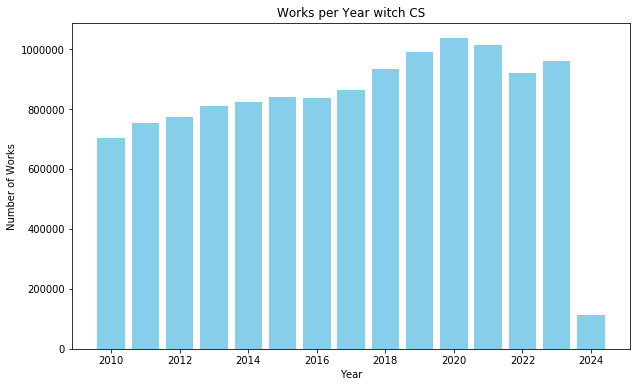

In [74]:
%%time

# Map and reduce to calculate the sum of articles per year
articles_per_year = isCS_2000_2024_rdd.map(lambda x: (x['year'], 1)) \
                                      .reduceByKey(lambda x, y: x + y) \
                                      .collect()

# Convert the result into lists for plotting
years, article_counts = zip(*articles_per_year)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(years, article_counts, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Works')
plt.title('Works per Year witch CS')

/vol/apps/python/gcc/3.7.5/gcc-6.3.0/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


CPU times: user 1min 49s, sys: 1min 45s, total: 3min 35s
Wall time: 17min 12s


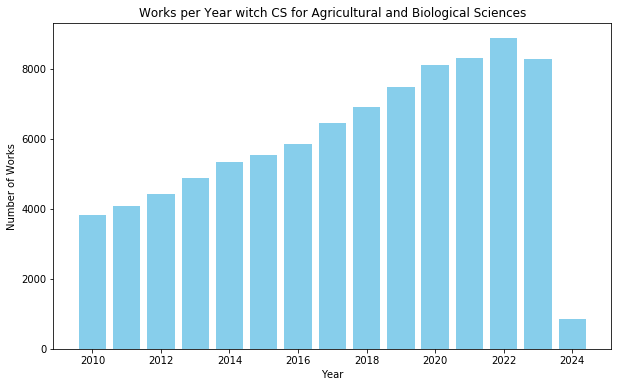

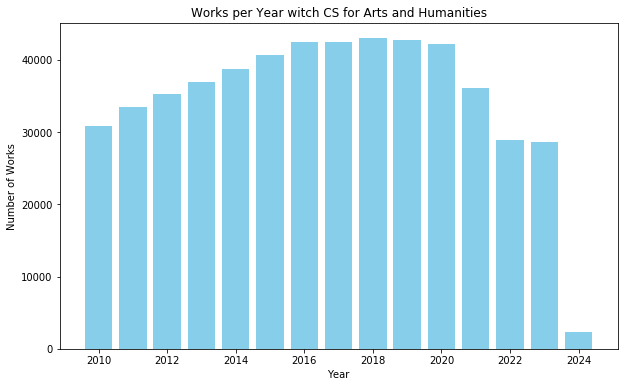

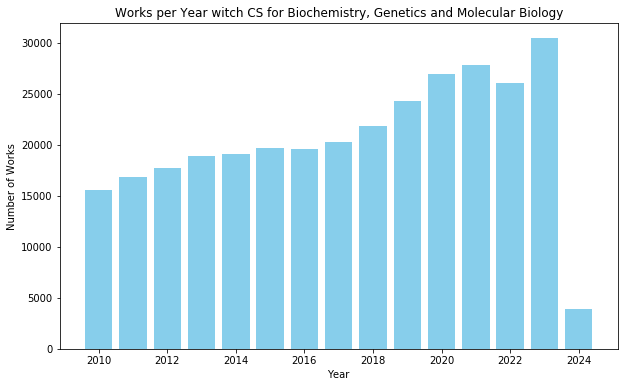

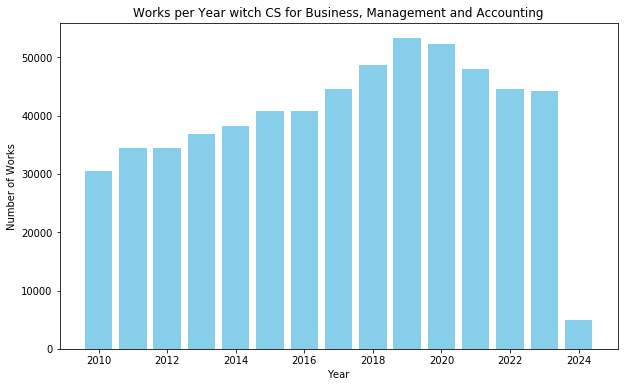

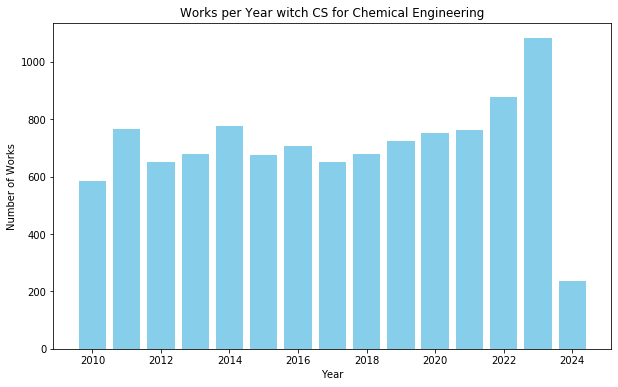

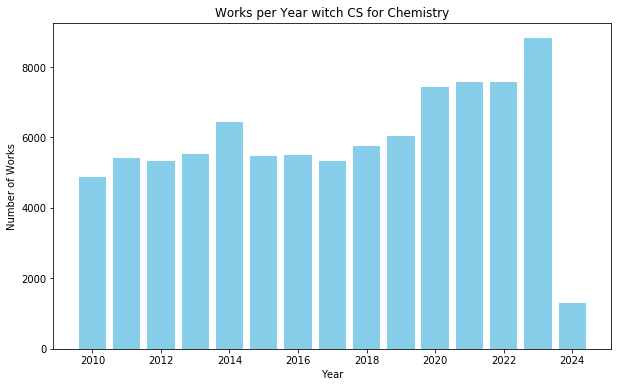

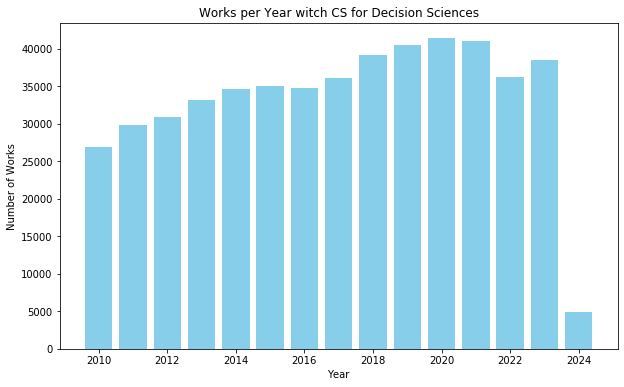

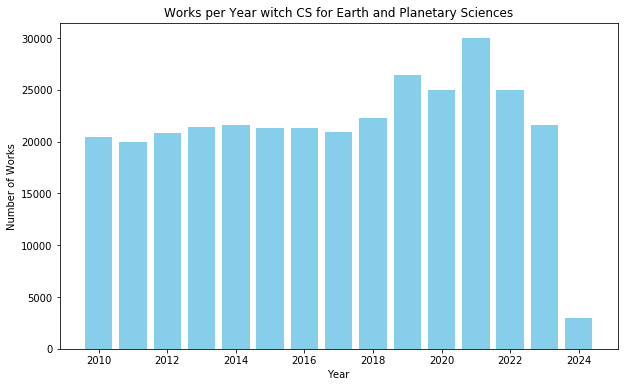

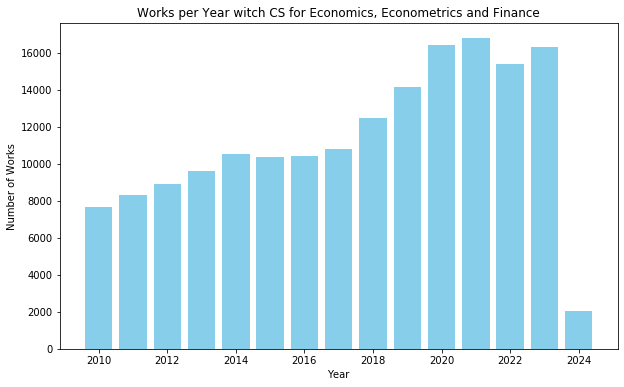

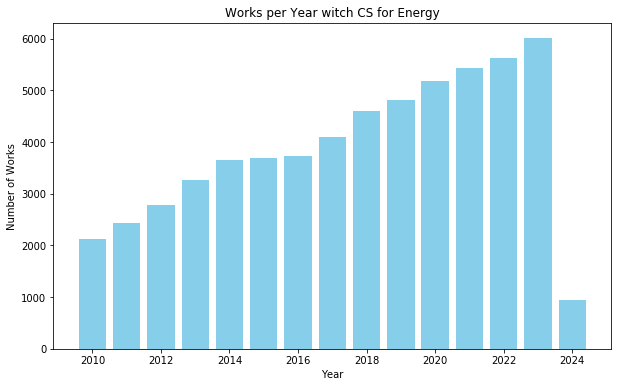

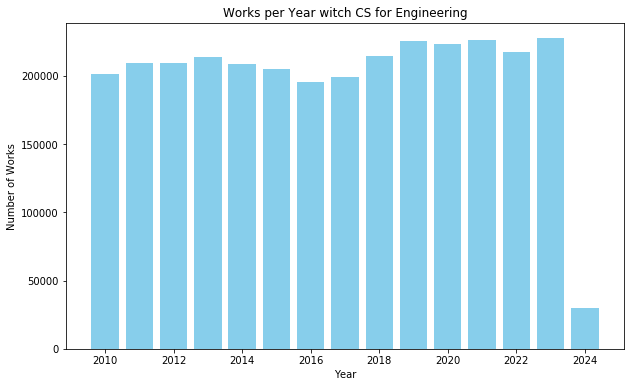

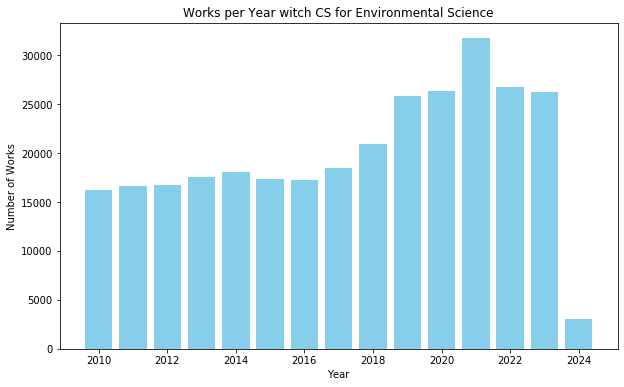

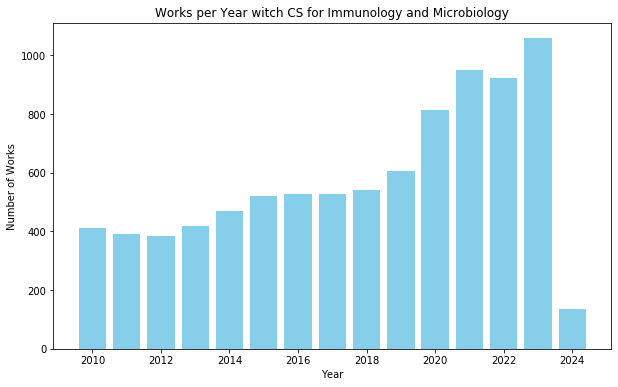

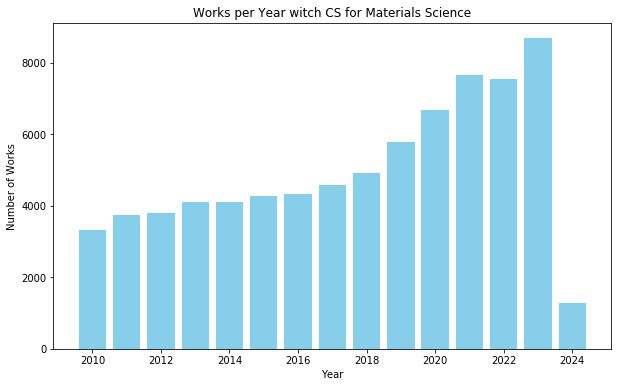

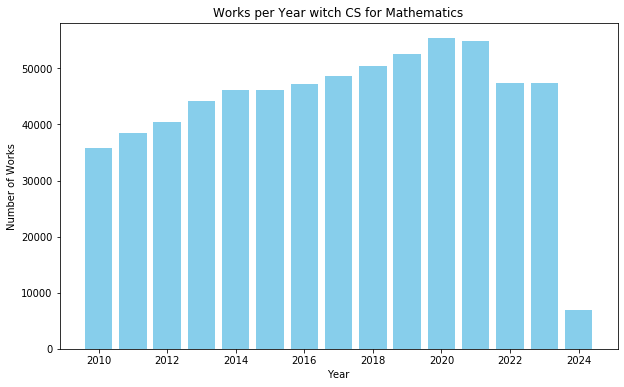

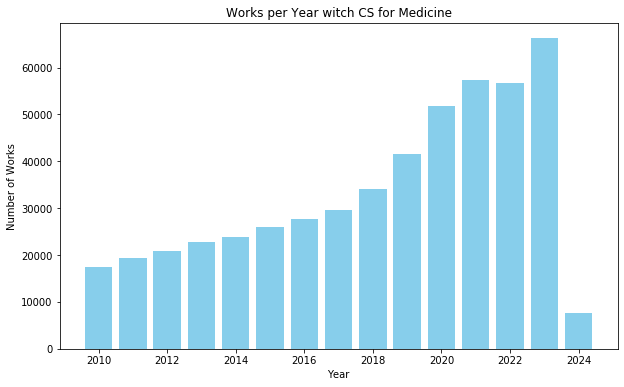

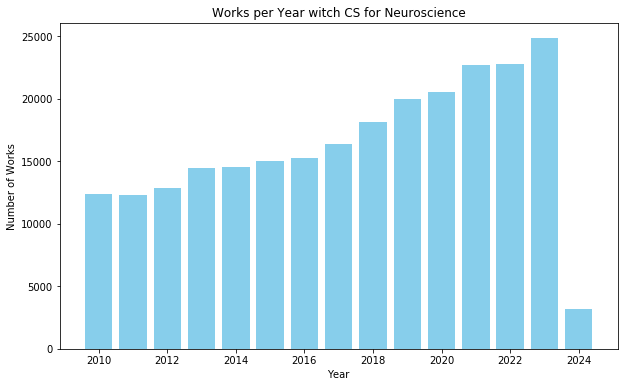

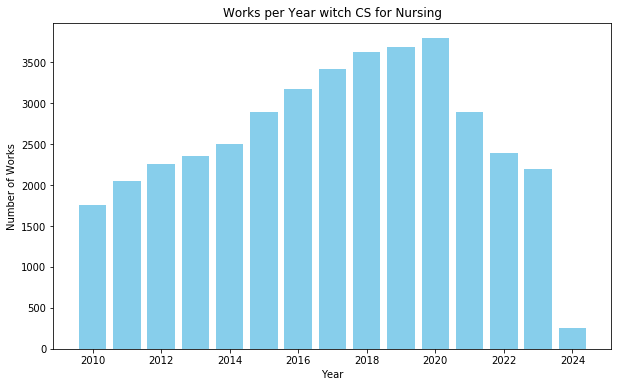

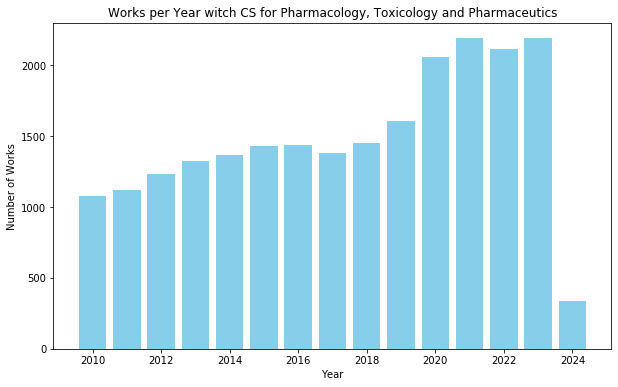

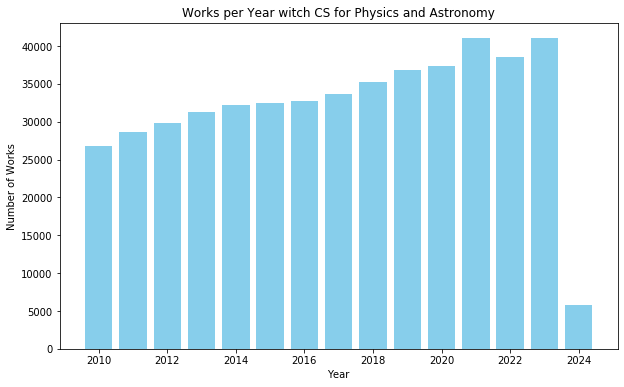

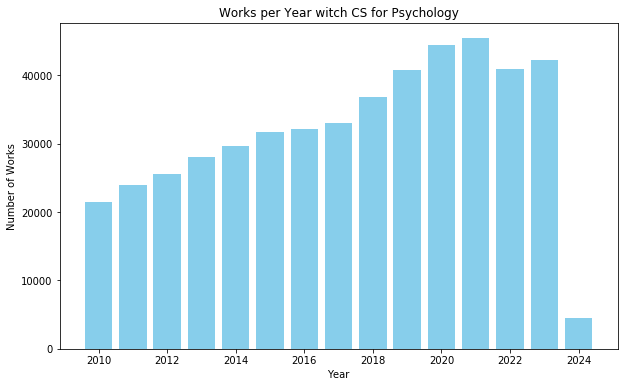

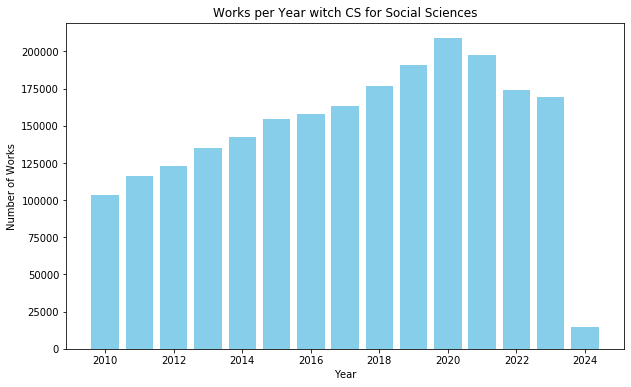

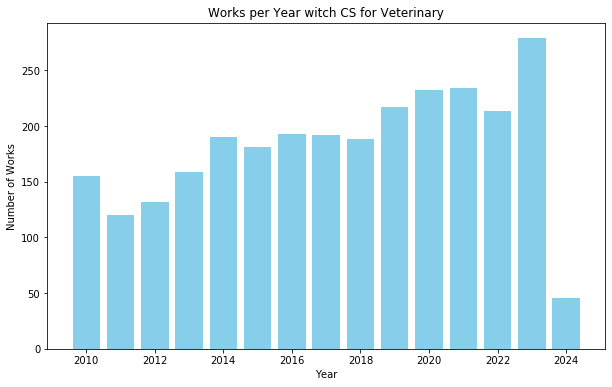

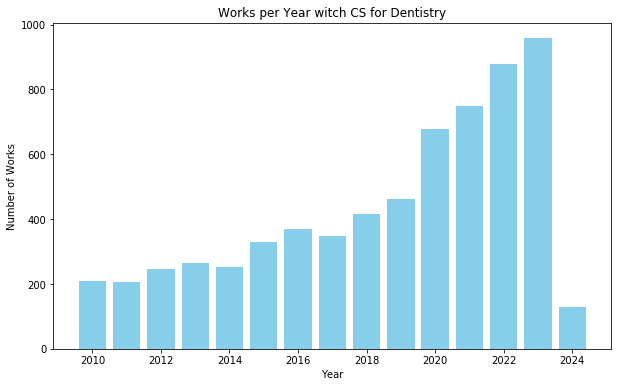

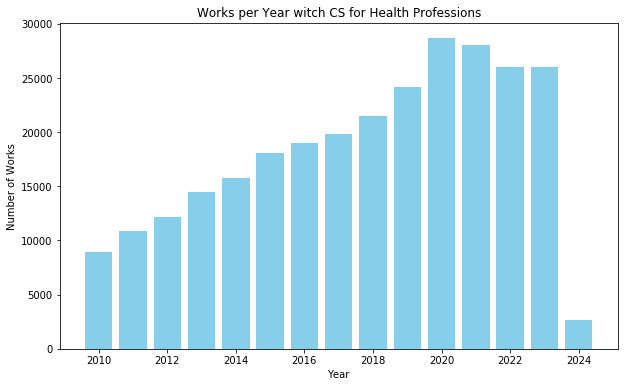

In [76]:
%%time
for code, name in topics.items():
    filtered_rdd = isCS_2000_2024_rdd.filter(lambda x:  any(topic == int(code) for topic in x.get('topics', [])))

    # Map the RDD to extract 'year' from each record
    year_rdd = filtered_rdd.map(lambda x: (x['year'], 1))

    # Reduce by key to calculate the sum of articles per year
    articles_per_year = year_rdd.reduceByKey(lambda x, y: x + y).collect()

    # Convert the result into lists for plotting
    years, article_counts = zip(*articles_per_year)

    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.bar(years, article_counts, color='skyblue')
    plt.xlabel('Year')
    plt.ylabel('Number of Works')
    plt.title(f"Works per Year with CS for {name}")

In [ ]:
%%time
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, when

filtered_rdd = rdd2.filter(lambda x:  x['isCS'] and x['year']>1999 and x['year']<2025 )

# Map the RDD to extract 'year' from each record
year_rdd = filtered_rdd.map(lambda x: (x['year'], 1))

# Reduce by key to calculate the sum of articles per year
articles_per_year = year_rdd.reduceByKey(lambda x, y: x + y).collect()

# Convert the result into lists for plotting
years, article_counts = zip(*articles_per_year)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(years, article_counts, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.title('Articles per Year')

In [70]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, BooleanType,LongType
import json

schema = StructType([
    StructField("id", LongType(), True),
    StructField("year", IntegerType(), True),
    StructField("type", StringType(), True),
    StructField("topics", ArrayType(IntegerType()), True),
    StructField("concepts", ArrayType(LongType()), True),
    StructField("referenced_works", ArrayType(LongType()), True),
    StructField("isCS", BooleanType(), True) 
])

# Convert RDD data to RDD of Rows
from pyspark.sql import Row
#rdd_rows = rdd_data.map(lambda x: Row(**json.loads(x)))

# Create DataFrame from RDD of Rows and the schema
df = spark.createDataFrame(rdd2, schema)

In [71]:
df.write.mode("overwrite").parquet("file:///scratch/jkarasev/parquet/rdd2")

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/home/jkarasev/.local/lib/python3.7/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/jkarasev/.local/lib/python3.7/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/vol/apps/python/gcc/3.7.5/gcc-6.3.0/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [25]:
#df = rdd2.toDF()

# Filter DataFrame to select only articles
article_df = df.filter(df['type'] == 'article')
article_df = article_df.filter(df['year'] >2000)

# Cast isCS column to integer type
article_df = article_df.withColumn("isCS", col("isCS").cast("int"))

# Group articles by year and calculate count of articles per year
articles_per_year = article_df.groupBy('year').count()

# Group articles by year and isCS value and calculate count of articles with isCS=True per year
articles_isCS_true_per_year = article_df.groupBy('year').agg({'isCS': 'sum'})

# Join the two DataFrames to combine the counts
articles_per_year_with_isCS_count = articles_per_year.join(articles_isCS_true_per_year, 'year', 'left_outer')

# Calculate percentage of articles with isCS=True per year
articles_per_year_with_isCS_count = articles_per_year_with_isCS_count.withColumn('percent_isCS', 
                                                (articles_per_year_with_isCS_count['sum(isCS)'] / articles_per_year_with_isCS_count['count']) * 100)

# Show the resulting DataFrame
articles_per_year_with_isCS_count.show()


+----+-------+---------+------------------+
|year|  count|sum(isCS)|      percent_isCS|
+----+-------+---------+------------------+
|2003|3806178|   327765| 8.611394422436366|
|2025|    753|      198|26.294820717131472|
|2007|5138462|   462688| 9.004406376849726|
|2018|7434360|   764211|  10.2794457088438|
|2015|7741515|   698885| 9.027754903271518|
|2023|6748601|   823655|12.204825859463316|
|2006|4870699|   438778| 9.008522185419382|
|2022|6533947|   783837| 11.99637829936484|
|2013|7376088|   678847| 9.203347357027193|
|2014|7592751|   689510|  9.08116175546913|
|2019|7719853|   829503| 10.74506211452472|
|2004|4119446|   336476| 8.167991521189984|
|2020|8004842|   882330|11.022453659922332|
|2012|7058146|   648986| 9.194850885770853|
|2009|6032161|   554228| 9.187884739813807|
|2016|7820862|   697759|     8.92176591276|
|2001|3139118|   193068| 6.150390014010305|
|2024| 893078|    96981|10.859185871782756|
|2005|4493957|   398105|   8.8586739926528|
|2010|6442970|   606753| 9.41728

In [29]:
# Sort the DataFrame by the "year" column
sorted_df = articles_per_year_with_isCS_count.orderBy("year")
sorted_df.persist()
# Show the sorted DataFrame
sorted_df.show()

+----+-------+---------+------------------+
|year|  count|sum(isCS)|      percent_isCS|
+----+-------+---------+------------------+
|2001|3139118|   193068| 6.150390014010305|
|2002|3688646|   381044|10.330186198404508|
|2003|3806178|   327765| 8.611394422436366|
|2004|4119446|   336476| 8.167991521189984|
|2005|4493957|   398105|   8.8586739926528|
|2006|4870699|   438778| 9.008522185419382|
|2007|5138462|   462688| 9.004406376849726|
|2008|5547815|   503095|  9.06834492498398|
|2009|6032161|   554228| 9.187884739813807|
|2010|6442970|   606753| 9.417287369023914|
|2011|6801122|   626928| 9.218008440372044|
|2012|7058146|   648986| 9.194850885770853|
|2013|7376088|   678847| 9.203347357027193|
|2014|7592751|   689510|  9.08116175546913|
|2015|7741515|   698885| 9.027754903271518|
|2016|7820862|   697759|     8.92176591276|
|2017|7428508|   710178| 9.560170090683082|
|2018|7434360|   764211|  10.2794457088438|
|2019|7719853|   829503| 10.74506211452472|
|2020|8004842|   882330|11.02245

In [30]:
sorted_df.show()

+----+-------+---------+------------------+
|year|  count|sum(isCS)|      percent_isCS|
+----+-------+---------+------------------+
|2001|3139118|   193068| 6.150390014010305|
|2002|3688646|   381044|10.330186198404508|
|2003|3806178|   327765| 8.611394422436366|
|2004|4119446|   336476| 8.167991521189984|
|2005|4493957|   398105|   8.8586739926528|
|2006|4870699|   438778| 9.008522185419382|
|2007|5138462|   462688| 9.004406376849726|
|2008|5547815|   503095|  9.06834492498398|
|2009|6032161|   554228| 9.187884739813807|
|2010|6442970|   606753| 9.417287369023914|
|2011|6801122|   626928| 9.218008440372044|
|2012|7058146|   648986| 9.194850885770853|
|2013|7376088|   678847| 9.203347357027193|
|2014|7592751|   689510|  9.08116175546913|
|2015|7741515|   698885| 9.027754903271518|
|2016|7820862|   697759|     8.92176591276|
|2017|7428508|   710178| 9.560170090683082|
|2018|7434360|   764211|  10.2794457088438|
|2019|7719853|   829503| 10.74506211452472|
|2020|8004842|   882330|11.02245

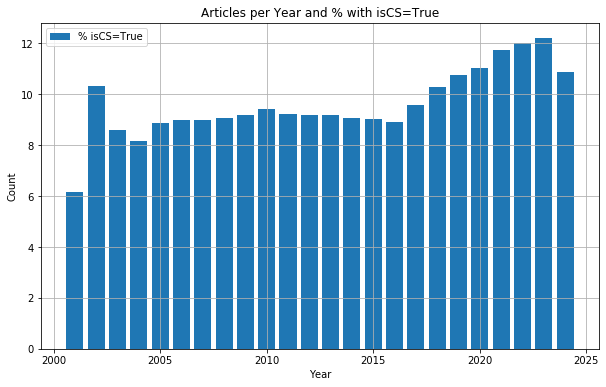

In [32]:
import pandas as pd

# Convert DataFrame to Pandas DataFrame for plotting
df_pandas = sorted_df.filter(sorted_df["year"] != 2025).toPandas()

# Plot graph
plt.figure(figsize=(10, 6))
#plt.bar(df_pandas['year'], df_pandas['count'], label='Total Articles')
plt.bar(df_pandas['year'], df_pandas['percent_isCS'], label='% isCS=True')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Articles per Year and % with isCS=True')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
pip install --upgrade pandas

In [ ]:
plt.clf()

In [58]:
spark.stop()

In [48]:
spark.local.dir

AttributeError: 'SparkSession' object has no attribute 'local'